In [1]:
# !uv sync --all-extras

In [2]:
%load_ext autoreload
%autoreload 2

import cryogrid_pytools as cg
import cryogrid_pytools.viz as viz
import pandas as pd
from cryogrid_pytools import data as cgdata

# Reading CryoGrid output

Currently only support for `read_OUT_regridded_FCI2`

In [3]:
fname = '/Users/luke/Git/CryoGrid-run-manager/runs/abramov-OUT_regridded/output/abramov-OUT_regridded_96252_19660901.mat'
cg.read_OUT_regridded_file(fname, deepest_point=-20)

<xarray.Dataset> Size: 12MB
Dimensions:       (time: 1461, level: 501)
Coordinates:
  * time          (time) datetime64[ns] 12kB 1965-09-01 ... 1966-09-01
    elevation     (level) float64 4kB dask.array<chunksize=(501,), meta=np.ndarray>
    depth         (level) float64 4kB dask.array<chunksize=(501,), meta=np.ndarray>
Dimensions without coordinates: level
Data variables:
    T             (level, time) float32 3MB dask.array<chunksize=(501, 1461), meta=np.ndarray>
    water         (level, time) float32 3MB dask.array<chunksize=(501, 1461), meta=np.ndarray>
    ice           (level, time) float32 3MB dask.array<chunksize=(501, 1461), meta=np.ndarray>
    class_number  (level, time) float32 3MB dask.array<chunksize=(501, 1461), meta=np.ndarray>
Attributes:
    filename:  /Users/luke/Git/CryoGrid-run-manager/runs/abramov-OUT_regridde...

In [4]:
fname_profiles = '/Users/luke/Git/CryoGrid-run-manager/runs/abramov-OUT_regridded/output/abramov-OUT_regridded_96252_*.mat'

out = cg.read_OUT_regridded_clusters(fname_profiles, deepest_point=-20)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [5]:
da = out.T[0].assign_attrs(long_name='Temperature', units='°C').compute()
ds = cg.analyze_profile(da)
ds

<xarray.Dataset> Size: 94MB
Dimensions:               (time: 15593, depth: 501, year: 11, stat: 7)
Coordinates:
  * time                  (time) datetime64[ns] 125kB 1960-01-01T06:00:00 ......
  * depth                 (depth) float64 4kB 5.0 4.95 4.9 ... -19.95 -20.0
    gridcell              int64 8B 96252
    elevation             (depth) float64 4kB 3.674e+03 3.674e+03 ... 3.649e+03
  * year                  (year) int64 88B 1960 1961 1962 ... 1968 1969 1970
  * stat                  (stat) object 56B 'mean' 'std' 'min' ... '75%' 'max'
Data variables:
    ground_temperature    (depth, time) float32 31MB nan nan ... -0.6431 -0.6431
    ground_thermal_state  (depth, time) float64 62MB nan nan nan ... nan nan nan
    active_layer_depth    (year) float64 88B -1.1 -1.4 -1.4 ... -0.7 -0.75 -0.85
    bottom_thawing_depth  (year) float64 88B nan nan nan nan ... nan nan nan nan
    permafrost_thickness  (year) float64 88B 18.9 18.6 18.6 ... 19.3 19.25 19.15
    active_layer_temp     (year, stat) float64 616B 0.1591 1.138 ... 17.51
    permafrost_temp       (year, stat) float64 616B -0.7779 ... -0.0001886
Attributes:
    description:  Properties of the ground temperature profile

Text(0.5, 1.0, '')

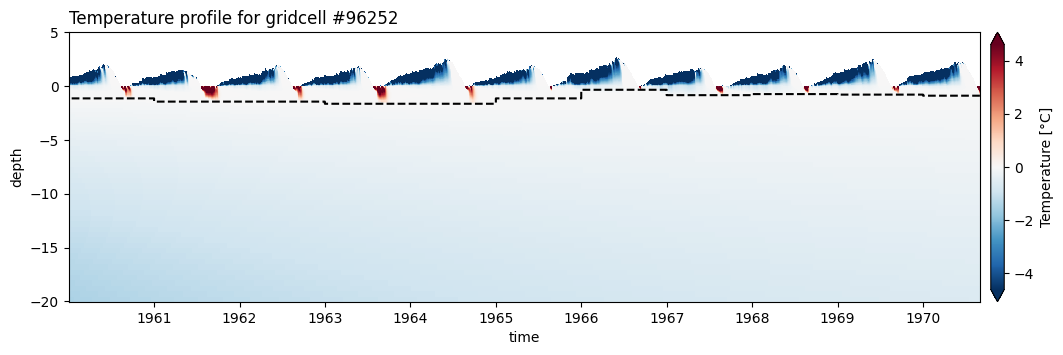

In [6]:
img = viz.plot_profile(ds.ground_temperature)
ds.ground_thermal_state.plot.contour(levels=[0.5, 1.5, 2.5], colors='k', ax=img.axes, linestyles='--')
img.axes.set_title('')

# Reading struct files from MATLAB


Note that `run_info.mat` cannot be read as it contains special classes that are not supported by `scipy.io.loadmat`.  

To save parts of `run_info`, use the following code in MATLAB:

<div style="background-color: #def0da; color: #64946D; padding: 16px 24px;">
 <div style="font-size: 16px; font-weight: bold;">ⓘ Tip for spatial data </div>
 <div style="font-size: 12px">
 To get spatial data from MATLAB, you need to save the data as shown in the code block below. The rest of the example in this code relies on this. 
 </div>
</div>

```matlab
run_info_spatial = run_info.SPATIAL.STATVAR
save "run_info_spatial.mat" run_info_spatial
```

In [7]:
import cryogrid_pytools.viz as viz
import rioxarray as rxr

fname_spatial = "/Users/luke/Work/PAMIR/CryoGrid/runs/abramov-large_area-strat/output/k100/run_spatial_info.mat"
fname_dem = "/Users/luke/Work/PAMIR/CryoGrid/runs/abramov-large_area-strat/forcing/cryogrid-pamir_abramov_strat-dem_cop_30m.tif"

# read in the spatial data 
ds_spatial = cg.read_mat_struct_as_dataset(
    fname_spatial, 
    index=['coord_y', 'coord_x'],  # set the index to the spatial coordinates - this maps the data to 2D
    drop_keys=['cluster_idx'],  # the cluster_idx is not the same size as the other data, so we drop it, but its added as a coordinate
)

# we have to assign a CRS to the spatial data. The DEM is used as a reference
crs = rxr.open_rasterio(fname_dem).rio.crs
# now we can write the CRS to the spatial data (this is important for plotting later on)
ds_spatial = (
    ds_spatial
    .rename(coord_y='y', coord_x='x')  # rioxarray expects the coordinates to be named x and y
    .rio.write_crs(crs)  # and set the CRS
)

In [8]:
ds_flat = cg.read_mat_struct_as_dataset(
    fname_spatial,  # when leaving out the index, the data is kept in its flat shape
    drop_keys=['cluster_idx'])  
# the mask removes all points that are not a cluster centroid
cluster_centroids = ds_flat.index.isin(ds_flat.cluster_idx)

gdf_locations = viz.gridpoints_to_geodataframe(ds_flat.sel(index=cluster_centroids))

### Plotting data on interactive map

We can use `folium` to plot the data on an interactive map.

In the `viz` module, there are some functions to help with this. The `plot_map` function automatically plots the data to a `folium` map. 

/Users/luke/Git/CryoGrid-pyTools/.venv/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:234: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)



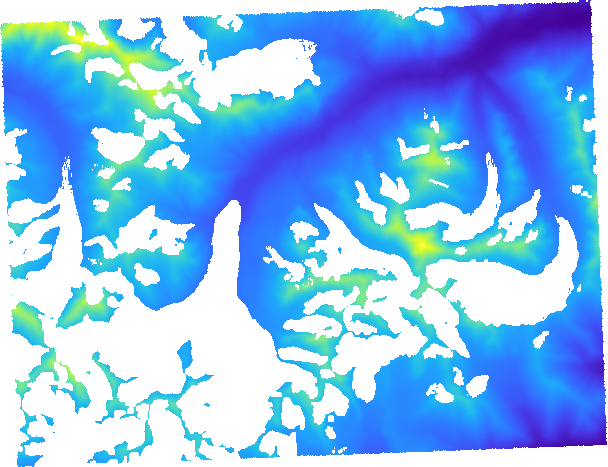

In [9]:
m = viz.plot_folium_map(ds_spatial.stratigraphy_index)
m = viz.plot_folium_map(ds_spatial.elevation, m=m)
m = gdf_locations.explore(m=m, name='Sample locations', **viz.MARKER_STYLES.blue_circle)
m = viz.finalize_folium_map(m)
m

# Reading Excel config files

This is experimental. Could be used to run checks on files, and configurations for the model.

In [10]:
fname_excel = '/Users/luke/Work/PAMIR/CryoGrid/runs/abramov-small-3classes/abramov-small-3classes.xlsx'
config = cg.CryoGridConfigExcel(fname_excel, check_file_paths=True, check_strat_layers=True)

2025-03-24 14:53:56 | INFO     - Found root path: /Users/luke/Work/PAMIR/CryoGrid/runs/abramov-small-3classes
2025-03-24 14:53:56 | SUCCESS  - Loaded CryoGrid Excel configuration file: /Users/luke/Work/PAMIR/CryoGrid/runs/abramov-small-3classes/abramov-small-3classes.xlsx
2025-03-24 14:53:56 | INFO     - Checking file locations...
2025-03-24 14:53:56 | SUCCESS  - Located file: /Users/luke/Work/PAMIR/CryoGrid/runs/abramov-small-3classes/forcing/era5.mat
2025-03-24 14:53:56 | SUCCESS  - Located file: /Users/luke/Work/PAMIR/CryoGrid/runs/abramov-small-3classes/forcing/elevation.tif
2025-03-24 14:53:56 | SUCCESS  - Located file: /Users/luke/Work/PAMIR/CryoGrid/runs/abramov-small-3classes/forcing/surface_classes.tif
2025-03-24 14:53:56 | INFO     - Checking stratigraphy layers...
2025-03-24 14:53:56 | SUCCESS  - [STRAT_layers_1]  parameters passed checks
2025-03-24 14:53:56 | SUCCESS  - [STRAT_layers_2]  parameters passed checks
2025-03-24 14:53:56 | SUCCESS  - [STRAT_layers_3]  parameters 

In [12]:
deepest_point = -config.get_output_max_depth()  # this can be used to find the maximum depth of the output
cg.read_OUT_regridded_clusters(fname_profiles, deepest_point)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


<xarray.Dataset> Size: 125MB
Dimensions:       (gridcell: 1, level: 501, time: 15593)
Coordinates:
  * gridcell      (gridcell) int64 8B 96252
  * time          (time) datetime64[ns] 125kB 1960-01-01T06:00:00 ... 1970-09-01
    elevation     (level) float64 4kB dask.array<chunksize=(501,), meta=np.ndarray>
    depth         (level) float64 4kB dask.array<chunksize=(501,), meta=np.ndarray>
Dimensions without coordinates: level
Data variables:
    T             (gridcell, level, time) float32 31MB dask.array<chunksize=(1, 501, 2436), meta=np.ndarray>
    water         (gridcell, level, time) float32 31MB dask.array<chunksize=(1, 501, 2436), meta=np.ndarray>
    ice           (gridcell, level, time) float32 31MB dask.array<chunksize=(1, 501, 2436), meta=np.ndarray>
    class_number  (gridcell, level, time) float32 31MB dask.array<chunksize=(1, 501, 2436), meta=np.ndarray>

# Reading ERA5 forcing data

<div style="background-color: #fcf8e5; color: #8C6D46; padding: 16px 24px;">
 <div style="font-size: 16px; font-weight: bold;">⚠ Warning</div>
 <div style="font-size: 12px">
 This is currently still in development. 
 </div>
</div>

In [13]:
fname = '/Users/luke/Work/PAMIR/CryoGrid/runs/abramov-small-3classes/forcing/era5.mat'
ds = cg.forcing.read_mat_ear5(fname)
ds

<xarray.Dataset> Size: 285MB
Dimensions:  (lon: 2, lat: 2, level: 8, time: 177273)
Coordinates:
  * lon      (lon) float32 8B 71.5 71.75
  * lat      (lat) float32 8B 40.0 39.75
  * level    (level) int64 64B 300 500 600 700 800 850 900 1000
  * time     (time) datetime64[ns] 1MB 1960-01-01 ... 2020-09-01
Data variables: (12/21)
    Zs       (time, lat, lon) float64 6MB 2.145e+03 2.274e+03 ... 3.679e+03
    u10      (time, lat, lon) float64 6MB -0.4 -0.13 -0.67 ... 0.02 -0.22 0.32
    v10      (time, lat, lon) float64 6MB 3.45 3.51 1.89 1.69 ... 0.63 0.86 0.61
    ps       (time, lat, lon) float64 6MB 7.91e+04 7.79e+04 ... 6.54e+04
    Td2      (time, lat, lon) float64 6MB -29.95 -30.95 -35.92 ... 0.46 0.46
    T2       (time, lat, lon) float64 6MB -11.62 -15.53 -15.41 ... 2.34 1.99
    ...       ...
    wind_sf  float64 8B 0.01
    q_sf     float64 8B 1e-06
    ps_sf    float64 8B 100.0
    rad_sf   float64 8B 0.1
    T_sf     float64 8B 0.01
    P_sf     float64 8B 0.01
Attributes:
    info:     Data read in from CryoGrid ERA5 forcing file. Data has been sca...
    source:   /Users/luke/Work/PAMIR/CryoGrid/runs/abramov-small-3classes/for...

In [14]:
fname = '/Users/luke/Work/PAMIR/archive/cryogrid-ITCH-ML/data/Tronfjell_summit.mat'
forcing = cg.read_mat_struct_as_dataset(fname, index='timeForcing', index_is_datenum=True)
forcing

<xarray.Dataset> Size: 28MB
Dimensions:       (timeForcing: 236688)
Coordinates:
  * timeForcing   (timeForcing) datetime64[ns] 2MB 1940-01-01 ... 2020-12-31T...
Data variables: (12/14)
    Tair          (timeForcing) float64 2MB -16.73 -14.74 ... -10.58 -10.85
    q             (timeForcing) float64 2MB 0.001008 0.001211 ... 0.001741
    wind          (timeForcing) float64 2MB 4.6 5.266 6.221 ... 2.616 1.707
    Sin_dir       (timeForcing) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sin_dif       (timeForcing) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sin           (timeForcing) float64 2MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...            ...
    p             (timeForcing) float64 2MB 8.247e+04 8.256e+04 ... 8.175e+04
    precip        (timeForcing) float64 2MB 0.0 0.0 0.0 ... 2.944 3.937 0.6699
    snowfall      (timeForcing) float64 2MB 0.0 0.0 0.0 ... 8.819 11.79 2.007
    rainfall      (timeForcing) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    azimuth       (timeForcing) float64 2MB 165.6 110.7 70.36 ... 272.7 227.6
    sunElevation  (timeForcing) float64 2MB -50.35 -36.42 ... -24.8 -44.19

# Creating forcing data (optional extra with additional dependencies)

I've built this as an extra module. To install the dependencies, you have to run 
```bash
pip install cryogrid_pytools[data]
```

There are a lot of additional requirements, so not recommended if you don't want to create forcing data. 

In [15]:
from cryogrid_pytools import data

In [16]:
# bbox created with http://bboxfinder.com/
bbox_WSEN = (71.44175183508192, 39.565609290405106, 71.70823768450587, 39.75237924473069)

### Downloading ERA5 data

Note this is simply a wrapper around the `era5_downloader` package that I also wrote. You can install this on its own with `pip install era5_downloader`.

Usage for that would be similar as shown below and there are fewer dependencies. The command to replicate the code below would be:

```python
era5_downloader = era5_downloader.create_cryogrid_forcing_fetcher(
    bbox_WSEN, region_name="abramov", dest_path=...)

In [ ]:
era5_downloader = data.make_era5_downloader(
    bbox_WSEN=bbox_WSEN,
    region_name='abramov_glacier',
    dest_path='./data/era5-{region_name}/{time:%Y}/era5-cryogrid_forcing-{region_name}-{time:%Y%m%d}.nc')

fname = era5_downloader.download("2019-01-01")  # downloads data for given date with the default configuration

# to create all data use the following - but note this can take days since you're downloading a lot of data
# flist = [era5_downloader.download(t) for t in pd.date_range('1960-01-01', '2024-10-01')]

2025-01-17 16:00:22.151 | INFO     | era5_downloader.core.__init__:547 | Initialized ERA5Downloader with 
ERA5Downloader(
    bbox = (71.44175183508192, 39.565609290405106, 71.70823768450587, 39.75237924473069), 
    levels = (300, 500, 600, 700, 800, 850, 900, 1000), 
    variables = (
        'geopotential',
        'temperature',
        'specific_humidity',
        'u_component_of_wind',
        'v_component_of_wind',
        '2m_dewpoint_temperature',
        'surface_thermal_radiation_downwards',
        'surface_solar_radiation_downwards',
        'toa_incident_solar_radiation',
        '10m_u_component_of_wind',
        '10m_v_component_of_wind',
        'surface_pressure',
        'total_precipitation',
        '2m_temperature'), 
    cache_path = '/Users/luke/Git/CryoGrid-pyTools/era5_downloader_tmp/20250117160020_k2fsp60f', 
    time_steps = (0, 3, 6, 9, 12, 15, 18, 21), 
    dest_path = './data/era5-abramov_glacier/{YYYY}/era5-cryogrid_forcing-abramov_glacier-{YYYYMMDD}.nc'

### Downloading data for spatial simulations

This includes:

- Copernicus 30 m DEM
- ESA land cover data for creating speculative stratigraphies (if you have no other option)
- Glacier masks from Randolph Glacier Inventory
- Mean snow melt day of year from 2018 to 2024 using Sentinel-2 scene classification data
